# Document clustering

## To-do:
  * [LDA](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
  * Parameterise stop words
  * Parameterise lemmatization
  * K-means clustering
  * Hierarchical clustering
  * Dimensionality reduction
  * Visualisation

In [1]:
import pandas as pd
import numpy as np
from time import time

# NLP
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering & Classification
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
# from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

In [3]:
df = pd.read_csv('data/amazon_alexa.tsv', sep='\t')

# remove documents with fewer than 10 words
df = df[df['verified_reviews'].apply(lambda x: len(x.split(' '))) >= 10].reset_index(drop=True)

df.head()

,rating,date,variation,verified_reviews,feedback
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1


In [4]:
df.shape

(1962, 5)

## Load language model, punctuation and stopwords

In [5]:
# load (medium-size) English language model and stopwords
nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
# list of punctuation
punctuations = string.punctuation

## Custom tokenizer
> See [here](https://github.com/explosion/spaCy/issues/3772#issuecomment-498008841) for using BERT or ELMo embeddings during tokenisation

In [6]:
# creating our tokenizer function
def custom_tokenizer(sentence):
    
    # remove newline chars, punctuation
    exclude = ['\n', '^', '[', '*', '-', ']', '’', '“', '”', '—', *string.punctuation]
    sentence = ''.join(ch for ch in sentence if ch not in exclude)
    
    # remove extra whitespace
    sentence = ' '.join(sentence.split())
    
    # creating our token object, which is used to create documents with linguistic annotations.
    tokens = nlp(sentence)

    # lemmatization, lowercase, strip extra whitespace
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]

    # remove stopwords
    tokens = [ w for w in tokens if w not in stop_words ]
    
    # return preprocessed list of tokens
    return tokens

In [7]:
df['text'] = df['verified_reviews'].apply(lambda x: ' '.join(token for token in custom_tokenizer(x)))

In [8]:
df.head()

,rating,date,variation,verified_reviews,feedback,text
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,play game answer question correctly alexa wron...
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing 4 yr old learn dinosaur control ...
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,receive echo gift need bluetooth play music ea...
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,cellphone use feature ipad use great alarm u r...
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,think 5th purchase work room house like featur...


## TFIDF vectorisation
> [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [10]:
# perform tfidf vectorisation using custom SpaCy tokenizer
vec = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    ngram_range=(1,2),  # allow bi-grams
    min_df=3,
    max_features=1500
)

X_tfidf = vec.fit_transform(df['verified_reviews'])

X_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vec.get_feature_names())

In [11]:
X_tfidf.head()

,1,10,100,1st,1st gen,1st generation,2,2 dot,2 week,20,...,yard,year,year old,yell,yes,young,youtube,youtube video,zigbee,👍
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X_tfidf.shape

(1962, 1500)

## Document vectors

In [13]:
# get document vectors for each card
X_vec = np.vstack([i for i in df['text'].apply(lambda x: nlp(x).vector)])
X_vec = pd.DataFrame(X_vec)

## K-means
> decide whether to use scaled tfidf weights or not

In [14]:
# let's try everything between 1 and 20 clusters
n_clusters = np.arange(1, 21)

# store errors for each value of k
errors = []

# for i between 1 and 20
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(StandardScaler().fit_transform(X_vec))
#     km.fit(X)
    # measure WCSS
    errors.append(km.inertia_)

### Determine number of clusters

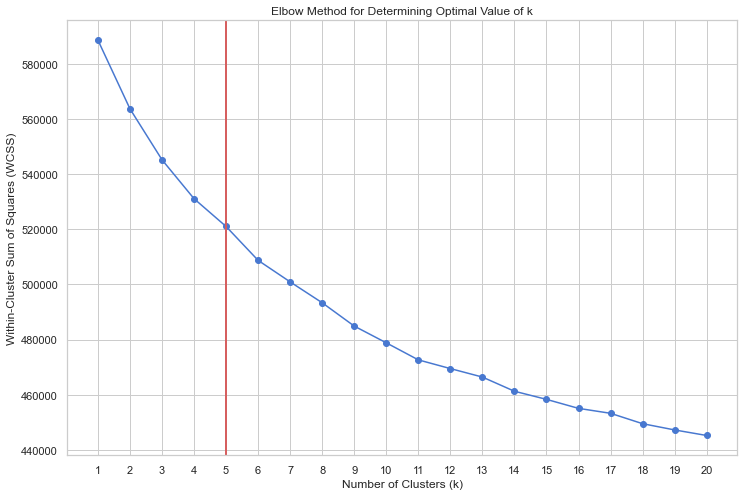

In [15]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)

# SET THE X-VALUE BELOW TO THE NUMBER OF CLUSTERS
# AT WHICH THE ELBOW OCCURS
plt.axvline(x=5, color='r', lw=2)
plt.show()

In [16]:
# set number of clusters based on elbow plot
k = 5

km = KMeans(n_clusters=k, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(StandardScaler().fit_transform(X_vec))
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(n_clusters=5, random_state=42)
done in 0.298s


In [17]:
# add cluster labels to df and X
df['km_cluster'] = km.labels_ + 1
X_vec['km_cluster'] = km.labels_ + 1
X_tfidf['km_cluster'] = km.labels_ + 1

df.head(10)

,rating,date,variation,verified_reviews,feedback,text,km_cluster
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,play game answer question correctly alexa wron...,3
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing 4 yr old learn dinosaur control ...,4
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,receive echo gift need bluetooth play music ea...,3
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,cellphone use feature ipad use great alarm u r...,2
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,think 5th purchase work room house like featur...,2
5,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1,love listen song hear childhood news weather i...,2
6,5,30-Jul-18,Charcoal Fabric,"I sent it to my 85 year old Dad, and he talks ...",1,send 85 year old dad talk constantly,4
7,5,30-Jul-18,Charcoal Fabric,I love it! Learning knew things with it eveyda...,1,love learning know thing eveyday figure work f...,1
8,5,30-Jul-18,Oak Finish,I purchased this for my mother who is having k...,1,purchase mother knee problem try come fast lik...,4
9,5,30-Jul-18,Heather Gray Fabric,Really happy with this purchase. Great speake...,1,happy purchase great speaker easy set,2


In [18]:
# show cluster sizes
df[['km_cluster']].value_counts()

km_cluster
4             608
3             559
2             488
1             301
5               6
dtype: int64

## Top tokens per cluster

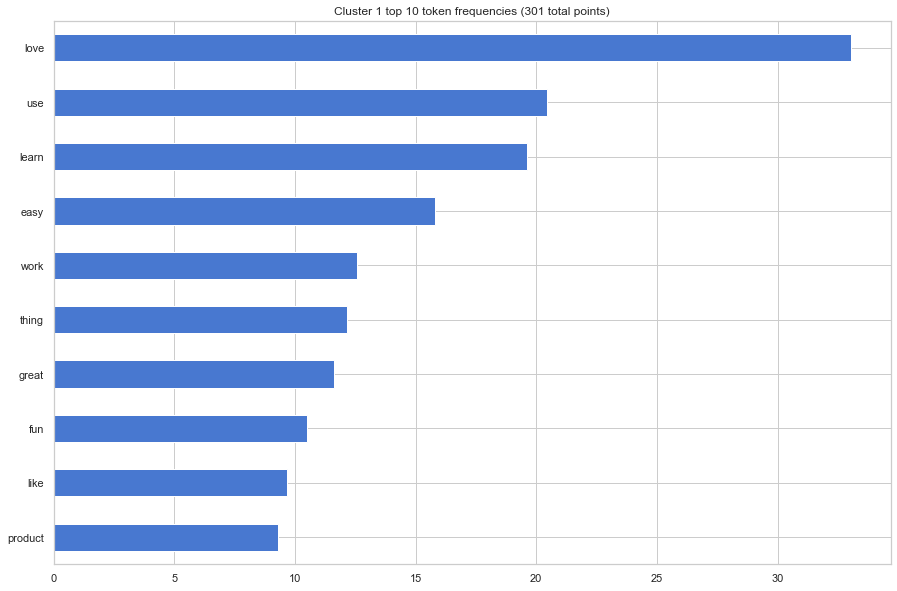

It is much more difficult to use than the Chromecast. 

I love how fast you get a respond from Alexa.Also easy to find any thing you are looking forjust speak in to the remote. 

Great product, easy to install and use! Not a necessity but a commodity! 

It's a great product with many good aspects, it easy to setup and control with intuitive straight forward instructions. The included lightbulb was excellent and worked perfectly. I very much enjoy this product and recommend it. 

outstanding I use all the time....works just like they say 



C:\Users\GGPC\anaconda3\envs\spacy\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


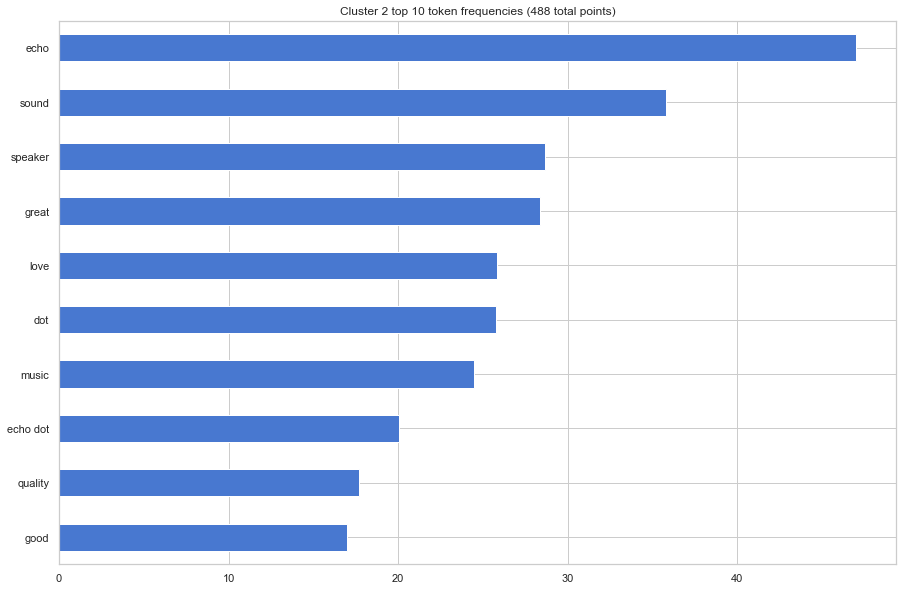

C:\Users\GGPC\anaconda3\envs\spacy\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


I was really happy with my original echo so i thought I'd get an echo dot to use in my bedroom. I was really disappointed in the audio quality so I connected an external speaker via bluetooth. The audio was much better but I started having problems with it loosing connection with the wifi, presumably due to interference from the bluetooth. Then  I connected a speaker via the auxiliary jack. when i did that, the auxiliary jack picked up interference from the wifi and I was woken up in the middle of the night by a horrible buzzing sound. im hoping Amazon will take this thing back and give me a good deal on an echo spot which I hope will be a better nightstand device. 

I was really happy with my original echo so i thought I'd get an echo dot to use in my bedroom. I was really disappointed in the audio quality so I connected an external speaker via bluetooth. The audio was much better but I started having problems with it loosing connection with the wifi, presumably due to interference fr

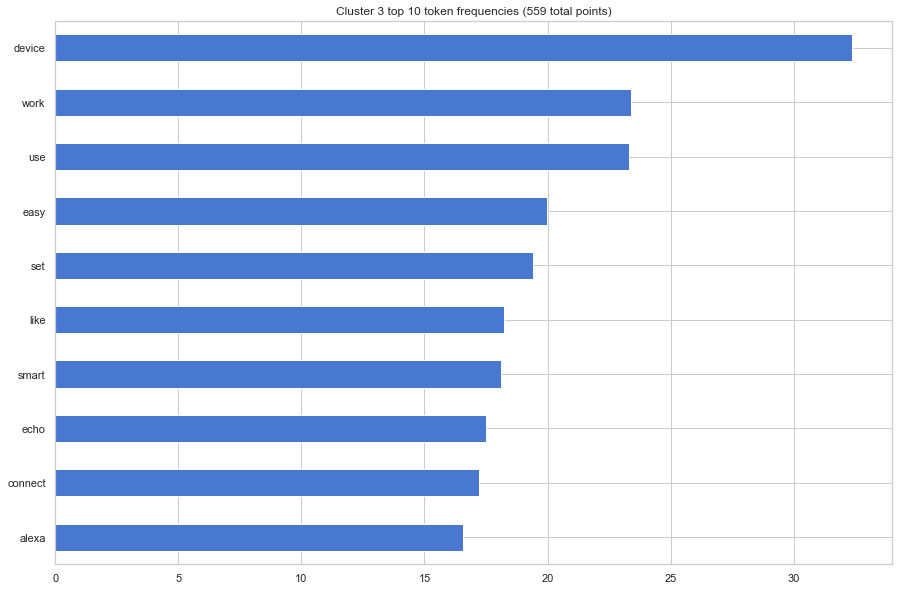

This product currently has two related software flaws that make it completely unusable:1) There is a &#34;card&#34; on the homescreen called &#34;Things To Try&#34; -- it's an ad for other Alexa services you can try. You can turn off all the other homescreen cards, but not this one.2) By default, the homescreen cards &#34;cycle&#34; automatically, which is incredibly annoying. There is a setting where you can opt to have the cards only &#34;cycle once&#34; instead of &#34;cycle continuously&#34;, but critically *this setting does not work*. My unit has been set to &#34;cycle once&#34;, and the cards still continue to cycle all the time. Have rebooted the device, re-set, etc etc.Until these two obvious software issues are fixed, in my opinion the product is useless. 

Haven't had it a week and already it cannot connect to my network. Tried reconnecting manually and the echo never appears in the list of devices to connect. It will be on it's way back to Amazon 

Got it for the smart hub 

C:\Users\GGPC\anaconda3\envs\spacy\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


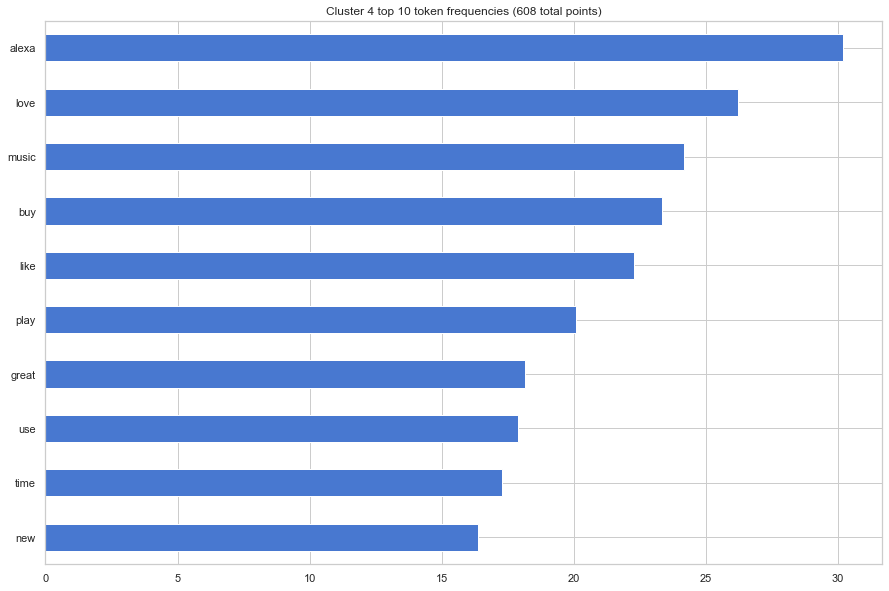

I don'r know how to use it yet.  Need more explicit directions for the electeonically challenged.  I did not get the feee lifht bulb that was part of the package. 

I will never buy anything Amazon makes again!This fire stick is not even a year old and it does nothing but restart and freeze up constantly. No warranty from Amazon in this should have been my first clue that it was a horrible device. I will never buy anything built by Amazon again. 

This refurbished item was fine,but I wasn't aware that there is a fee for having other echos set up in the rooms.  However, it was missing the cordThank you 

The ability to respond with the accuracy and variety of information provided by Google search has spoiled me.I had originally expected to see that the same type of search engine in the Echo.Not so, the ability of Alexa to provide such detailed information is not part of the package.Perhaps improvements are in the offing with further updates. 

Was working great útil 1 week algo, í have 

C:\Users\GGPC\anaconda3\envs\spacy\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


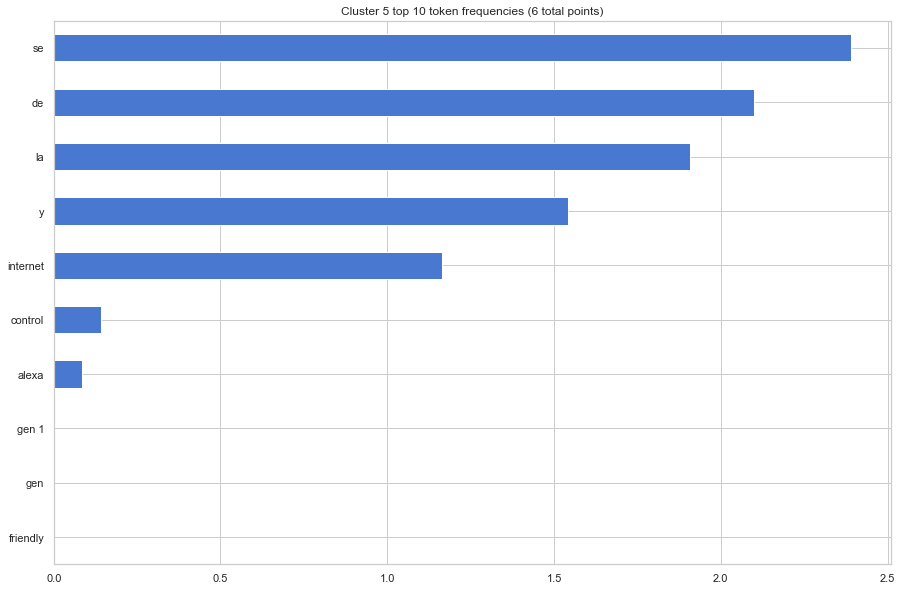

Un excelente equipo inteligente al estar conectado al internet nos provee de múltiples funciones tales como, el tiempo,hora,información de cualquier estudio que estés realizando atrás vez del internet. 

Un excelente equipo inteligente al estar conectado al internet nos provee de múltiples funciones tales como, el tiempo,hora,información de cualquier estudio que estés realizando atrás vez del internet. 

Excelente su funcionamiento y llama la atención la rapidez de respuesta y el control que se logra a través de la utilización con Alexa. Me sorprendió gratamente. Muy recomendable. 

Este producto llegó y a la semana se quedó sin olor, perdió toda su escencia, huele solo a alcohol 

Este producto llegó y a la semana se quedó sin olor, perdió toda su escencia, huele solo a alcohol 



C:\Users\GGPC\anaconda3\envs\spacy\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
for cluster in range(k):
    
    n = cluster + 1
    
    # get documents in cluster
    cluster_df = df[df['km_cluster'] == n]
    
    # get document vectors in cluster
    cluster_vec = X_vec[X_vec['km_cluster'] == n].drop(['km_cluster'], axis=1)

    # get tfidf weights in cluster
    cluster_tfidf = X_tfidf[X_tfidf['km_cluster'] == n].drop(['km_cluster'], axis=1)

    # number of points in cluster
    n_points = len(df[df['km_cluster'] == n])

    # top 10 words per cluster
    cluster_tfidf.sum().T.sort_values().tail(10).plot(kind='barh')
    plt.title(f'Cluster {n} top 10 token frequencies ({n_points} total points)')
    plt.show()
    
    # get top 5 closest documents to cluster centroid
    cluster_df['distance'] = metrics.pairwise_distances(cluster_vec, km.cluster_centers_[2,:].reshape(1, -1))
    for document in cluster_df.sort_values('distance').head().verified_reviews.values:
        print(document, '\n')

## Dimensionality reduction

In [21]:
mds = MDS(n_components=2, 
          n_init=2, 
          max_iter=200,
          n_jobs=-1,
          random_state=42,
          dissimilarity='euclidean')

print('Computing MDS...')
t0 = time()
X_mds = mds.fit_transform(StandardScaler().fit_transform(X_vec))
print(f'Completed in {time() - t0} seconds, Stress: {mds.stress_}')

Computing MDS...
Completed in 22.227911949157715 seconds, Stress: 139794819.77507284


In [22]:
df['mds_1'] = X_mds[:,0]
df['mds_2'] = X_mds[:,1]

df.head()

,rating,date,variation,verified_reviews,feedback,text,km_cluster,mds_1,mds_2
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,play game answer question correctly alexa wron...,3,7.243803,9.174800
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing 4 yr old learn dinosaur control ...,4,-7.060811,8.000950
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,receive echo gift need bluetooth play music ea...,3,-9.533078,-4.012028
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,cellphone use feature ipad use great alarm u r...,2,-5.383578,3.722717
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,think 5th purchase work room house like featur...,2,-7.204781,1.227274


In [25]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2,
            perplexity=40,
            metric='euclidean',
            init='pca',
            verbose=1,
            random_state=42)
t0 = time()
X_tsne = tsne.fit_transform(StandardScaler().fit_transform(X_vec))
print(f'Completed in {time() - t0} seconds')

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1962 samples in 0.073s...
[t-SNE] Computed neighbors for 1962 samples in 1.698s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1962
[t-SNE] Computed conditional probabilities for sample 1962 / 1962
[t-SNE] Mean sigma: 4.830328
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.025650
[t-SNE] KL divergence after 1000 iterations: 1.939105
Completed in 7.0058064460754395 seconds


In [26]:
df['tsne_1'] = X_tsne[:,0]
df['tsne_2'] = X_tsne[:,1]

df.head()

,rating,date,variation,verified_reviews,feedback,text,km_cluster,mds_1,mds_2,tsne_1,tsne_2
0,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,play game answer question correctly alexa wron...,3,7.243803,9.174800,-7.653715,19.546265
1,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing 4 yr old learn dinosaur control ...,4,-7.060811,8.000950,-7.384084,39.968838
2,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,receive echo gift need bluetooth play music ea...,3,-9.533078,-4.012028,-57.137028,-7.871737
3,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,cellphone use feature ipad use great alarm u r...,2,-5.383578,3.722717,-18.240404,6.046954
4,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,think 5th purchase work room house like featur...,2,-7.204781,1.227274,-10.804560,-23.010267


## Visualisation

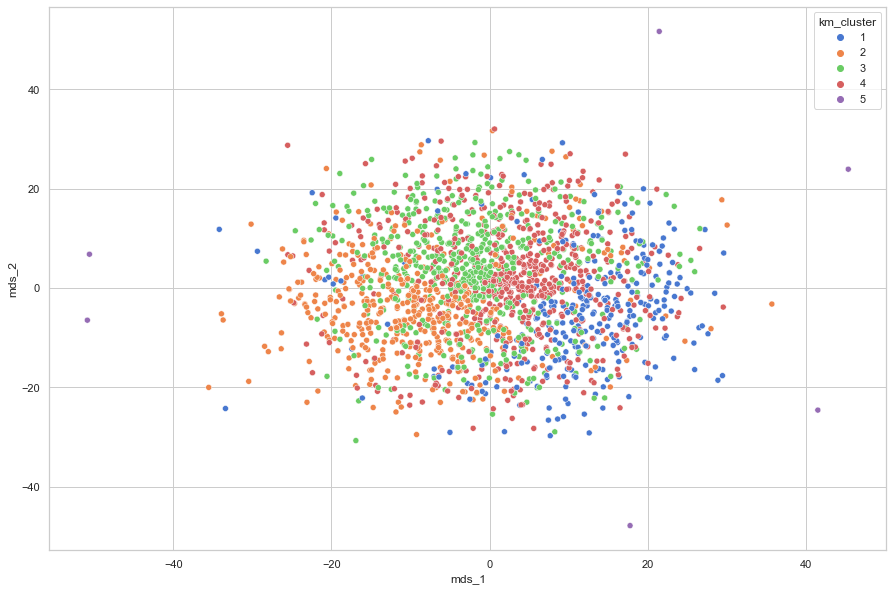

In [27]:
ax = sns.scatterplot(x='mds_1', y='mds_2', hue='km_cluster', data=df, palette=sns.color_palette(n_colors=k))
plt.show()

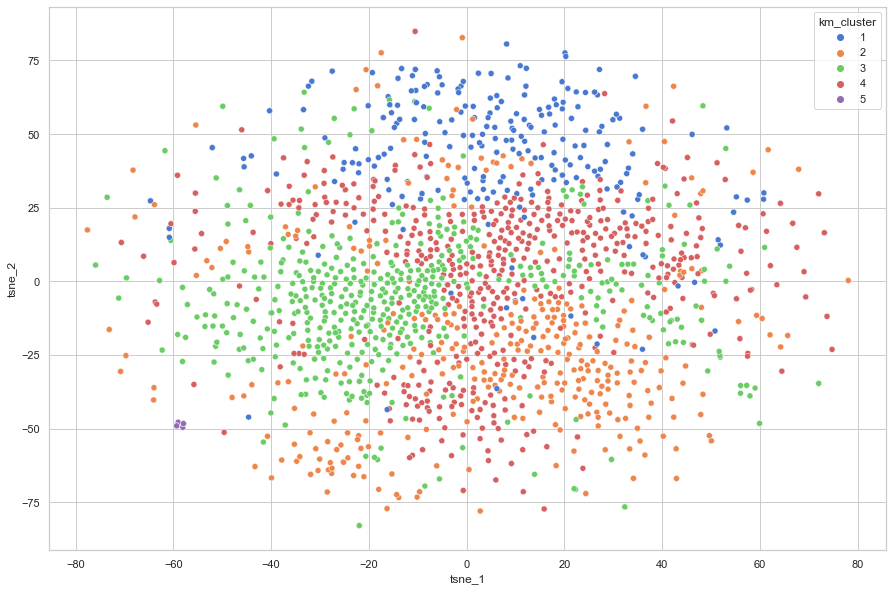

In [28]:
ax = sns.scatterplot(x='tsne_1', y='tsne_2', hue='km_cluster', data=df, palette=sns.color_palette(n_colors=k))
plt.show()